# Active Learning on a 2D toy example

This notebook demonstrates how to apply a variety of acquisition functions for doing active learning on a simple 2D classification problem. Both classic acquisition functions as well as a prediction-oriented one is considered. These are:
- Variation Ratios - VR ($formula$)
- Bayesian Active Learning by Disagreement - BALD ($formula$)
- Expected Predictive Information Gain - EPIG ($formula$)

In [31]:
import os

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from src.visualization.toy_example import plot_data, show_density_grid, show_acquisition_grid
from src.data.toy_example import generate_data
from src.methods.acquisition_functions import VariationRatios, BALD, EPIG

### Data generation

For illustrating a variety of active learning methods a 2D toy example is considered. The specific one at hand is the non-linear classification task associated with `sklearn`'s `make_moons`-dataset. As defined below, the data configuration consists of $N_{initial} = 5$, $N_{test}=100$ and $N_{pool}=500$ data points.

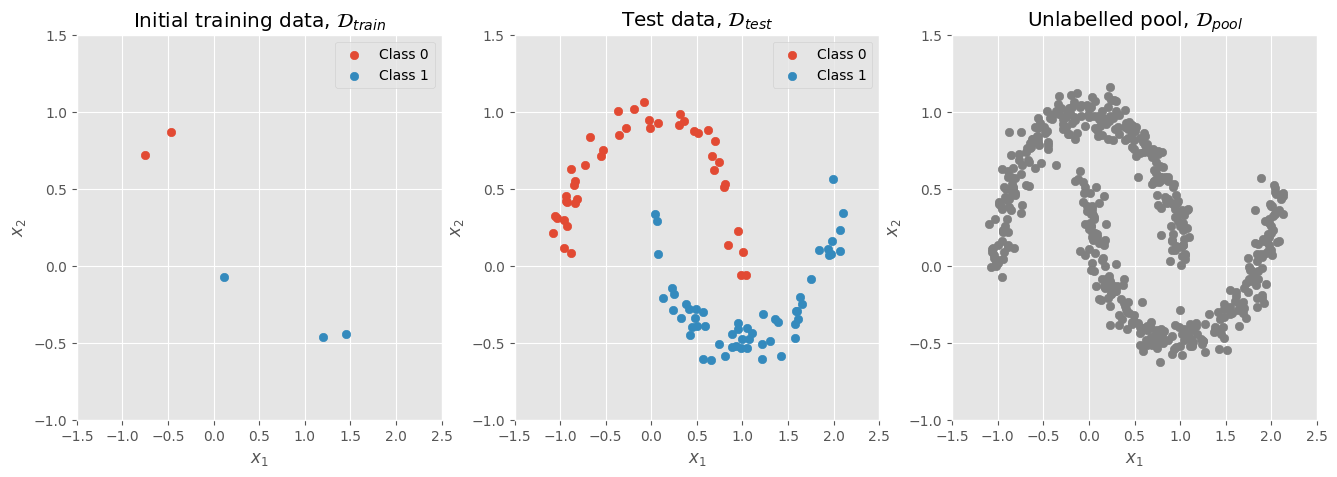

In [2]:
np.random.seed(0)

# Define dataset sizes
N_initial   = 5
N_test      = 100
N_pool      = 500

# Generate dataset partitions
Xtrain, ytrain, Xtest, ytest, Xpool, ypool = generate_data(N_initial=N_initial, N_test=N_test, N_pool=N_pool)

# Plot the dataset partitions
plot_data(Xtrain, ytrain, Xtest, ytest, Xpool, ypool)

### Visualizing model predictions

For optimally querying the pool for new data points, a model outputting proper uncertainty estimates is a strict requirement. For simplicity, we consider a Gaussian Process (GP) classification model and exploit `sklearn` for an easy implementation.   

In [3]:
# Define model
model = GaussianProcessClassifier(1.0 * RBF(1.0))

# Train model
model.fit(Xtrain, ytrain)
# Show performance
print(f"ACCURACY\n  -> train: {model.score(Xtrain, ytrain)}\n  -> test: {model.score(Xtest, ytest)}")

ACCURACY
  -> train: 1.0
  -> test: 0.86


As is validly seen from the above results, the test performance suffers from the small size of the training data. As such, we approach selection of additional data points through active learning. In the following cell, one data point is queried by exploiting the `VariationRatios` acquisition function.

In [38]:

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable


def plot_data(Xtrain, ytrain, Xtest, ytest, Xpool, ypool):
    fig = plt.figure(figsize=(16, 5))

    ax = fig.add_subplot(131)
    for i in range(2):
        ax.scatter(Xtrain[ytrain == i, 0], Xtrain[ytrain == i, 1], color=f'C{i}', label=f'Class {i}')
    ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
    ax.set_xlim([-1.5, 2.5]); ax.set_ylim([-1, 1.5])
    ax.set_title('Initial training data, $\mathcal{D}_{train}$')
    ax.legend()

    ax = fig.add_subplot(132)
    for i in range(2):
        ax.scatter(Xtest[ytest == i, 0], Xtest[ytest == i, 1], color=f'C{i}', label=f'Class {i}')
    ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
    ax.set_xlim([-1.5, 2.5]); ax.set_ylim([-1, 1.5])
    ax.set_title('Test data, $\mathcal{D}_{test}$')
    ax.legend()

    ax = fig.add_subplot(133)
    ax.scatter(Xpool[:, 0], Xpool[:, 1], color=f'gray')
    ax.set_xlabel('$x_1$'); ax.set_ylabel('$x_2$')
    ax.set_xlim([-1.5, 2.5]); ax.set_ylim([-1, 1.5])
    ax.set_title('Unlabelled pool, $\mathcal{D}_{pool}$')
    plt.show()

def add_colorbar(im, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

def get_density_grid(model, x1_low, x1_high, x2_low, x2_high, P=200):
    # Generate a sample 2D density grid
    x1              = np.linspace(x1_low, x1_high, P)
    x2              = np.linspace(x2_low, x2_high, P)
    X1, X2          = np.meshgrid(x1, x2)
    XX              = np.column_stack((X1.ravel(), X2.ravel()))

    # Get uncertainty output from model
    density_grid    = model.predict_proba(XX)[:, 0].reshape(P, P) # binary case
    return x1, x2, density_grid

def show_density_grid(model, Xtrain, Xtest, ytrain, ytest, zoom=([-2, 2], [-2, 2]), P=200, figsize=(6,5), ax=None, fig=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, squeeze=False)
        ax      = ax[0][0]

    # Get density grid
    x1, x2, density_grid = get_density_grid(model, x1_low=zoom[0][0], x1_high=zoom[0][1], x2_low=zoom[1][0], x2_high=zoom[1][1], P=P)
    
    # Plot density grid
    im = ax.pcolormesh(x1, x2, density_grid, cmap=plt.cm.RdBu_r, norm=colors.CenteredNorm(0.5), shading='auto')

    # Plot training points
    ax.scatter(Xtrain[:, 0], Xtrain[:, 1], color='k', s=50, label='Training data')

    # Plot all data, colored by respective category
    X_, y_ = np.append(Xtrain, Xtest, axis=0), np.append(ytrain, ytest)
    for i in range(2):
        ax.scatter(X_[y_ == i, 0], X_[y_ == i, 1], color=f'C{i}', label=f'Class {i}', s=20)

    # Add label
    ax.set_xlabel('$x_1$');      
    ax.set_ylabel('$x_2$')
    ax.set_xlim(zoom[0]);    
    ax.set_ylim(zoom[1])
    ax.set_title(f'Decision boundary')

    # Add colorbar
    add_colorbar(im, fig, ax)
    return ax

def show_acquisition_grid(model, acq_fun, Xtrain, ytrain, Xpool, zoom=([-2, 2], [-2, 2]), P=200, ax=None, fig=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize, squeeze=False)
        ax      = ax[0][0]

    # Get density grid
    x1, x2, density_grid = get_density_grid(model, x1_low=zoom[0][0], x1_high=zoom[0][1], x2_low=zoom[1][0], x2_high=zoom[1][1], P=P)
    
    # Get acquisition function values
    density_grid_matrix     = np.vstack([density_grid.flatten(), 1-density_grid.flatten()]).T
    acq_scores, _           = acq_fun(density_grid_matrix, return_sorted=False)
    acq_score_grid          = acq_scores.reshape(P, P)

    # Plot density grid
    im = ax.pcolormesh(x1, x2, acq_score_grid, cmap=plt.cm.Greens, norm=colors.Normalize(), shading='auto')

    # Plot unlabelled pool
    ax.scatter(Xpool[:, 0], Xpool[:, 1], color=f'gray', label=f'Unlabelled pool', s=20, alpha=0.5)
    # Plot training points
    ax.scatter(Xtrain[:, 0], Xtrain[:, 1], color='k', s=50, label='Training data')
    # Color training points by their respective category
    for i in range(2):
        ax.scatter(Xtrain[ytrain == i, 0], Xtrain[ytrain == i, 1], color=f'C{i}', label=f'Class {i}', s=20)

    # Add label
    ax.set_xlabel('$x_1$');      
    ax.set_ylabel('$x_2$')
    ax.set_xlim(zoom[0]);    
    ax.set_ylim(zoom[1])
    ax.set_title(f'Acquisition function - {acq_fun.name}')

    # Add colorbar
    add_colorbar(im, fig, ax)
    return ax

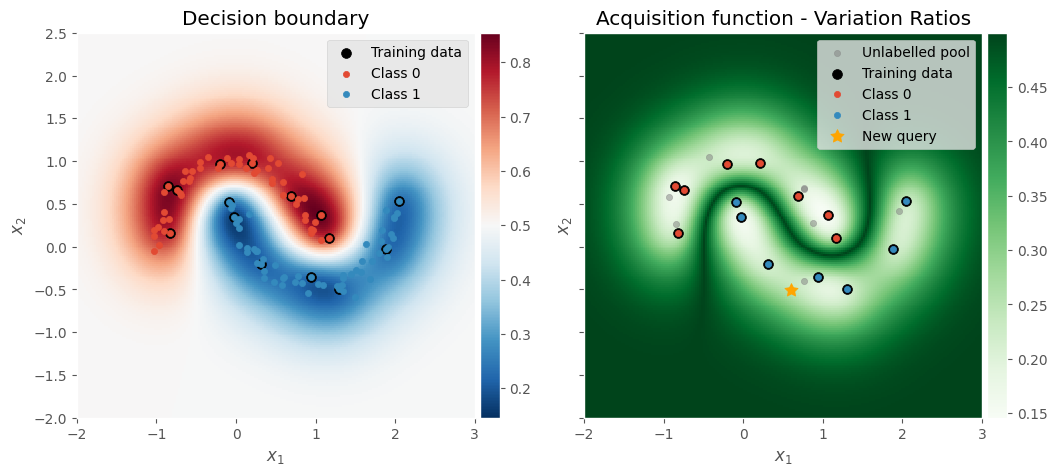

In [61]:
# Define acquisition function
acq_fun = VariationRatios(query_n_points=None)

# Get posterior predictive of data in the pool
pool_probs = model.predict_proba(Xpool)

# Get acquisition function score and the items to query
_, query_idxs = acq_fun(pool_probs)
next_query = Xpool[query_idxs[0]]


### PLOT DECISION BOUNDARY AND ACQUISITION FUNCTION ###
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

# Plot model uncertainty across grid
axs[0] = show_density_grid(model, Xtrain, Xtest, ytrain, ytest, zoom=([-2, 3], [-2, 2.5]), ax=axs[0], fig=fig)
axs[0].legend()

# Plot acquisition function across a grid
axs[1] = show_acquisition_grid(model, acq_fun, Xtrain, ytrain, Xpool, zoom=([-2, 3], [-2, 2.5]), P=200, ax=axs[1], fig=fig)
axs[1].scatter(next_query[0], next_query[1], color='orange', marker=(5, 1), s=100, label='New query')
axs[1].legend()

plt.show()

### Running the active learning loop

In [69]:
np.random.seed(0)

# Define dataset sizes
N_initial   = 4
N_test      = 100
N_pool      = 20

# Generate dataset partitions
Xtrain, ytrain, Xtest, ytest, Xpool, ypool = generate_data(N_initial=N_initial, N_test=N_test, N_pool=N_pool)

os.makedirs('../reports/figures/2D_toy/example/', exist_ok=True)
for i in range(N_pool):
    # Define model
    model = GaussianProcessClassifier(1.0 * RBF(1.0))

    # Train model
    model.fit(Xtrain, ytrain)
    
    # Show performance
    print(f"Train acc.: {model.score(Xtrain, ytrain):.2f} \t| Test acc.: {model.score(Xtest, ytest):.2f} \t| Trainset: {Xtrain.__len__()} \t| Pool: {Xpool.__len__()}")

    # Define acquisition function
    acq_fun = VariationRatios(query_n_points=None)

    # Get posterior predictive of data in the pool
    pool_probs = model.predict_proba(Xpool)

    # Get acquisition function score and the items to query
    _, query_idxs               = acq_fun(pool_probs)
    X_next_query, y_next_query  = Xpool[query_idxs[0]], ypool[query_idxs[0]]


    ### PLOT DECISION BOUNDARY AND ACQUISITION FUNCTION ###
    fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True, sharex=True)

    # Plot model uncertainty across grid
    axs[0] = show_density_grid(model, Xtrain, Xtest, ytrain, ytest, zoom=([-2, 3], [-2, 2.5]), ax=axs[0], fig=fig)
    axs[0].legend()

    # Plot acquisition function across a grid
    axs[1] = show_acquisition_grid(model, acq_fun, Xtrain, ytrain, Xpool, zoom=([-2, 3], [-2, 2.5]), P=200, ax=axs[1], fig=fig)
    axs[1].scatter(X_next_query[0], X_next_query[1], color='orange', marker=(5, 1), s=100, label='New query')
    axs[1].legend()

    plt.savefig(f'../reports/figures/2D_toy/example/iteration{i}.png')
    plt.close()


    ### UPDATE TRAINING SET AND POOL ACCORDINGLY ###
    Xtrain  = np.vstack([Xtrain, X_next_query])
    ytrain  = np.hstack([ytrain, y_next_query])
    Xpool   = np.delete(Xpool, query_idxs[0], 0)
    ypool   = np.delete(ypool, query_idxs[0], 0)

Train acc.: 1.00 	| Test acc.: 0.80 	| Trainset: 4 	| Pool: 20
Train acc.: 1.00 	| Test acc.: 0.81 	| Trainset: 5 	| Pool: 19
Train acc.: 1.00 	| Test acc.: 0.90 	| Trainset: 6 	| Pool: 18
Train acc.: 1.00 	| Test acc.: 0.96 	| Trainset: 7 	| Pool: 17
Train acc.: 1.00 	| Test acc.: 0.96 	| Trainset: 8 	| Pool: 16
Train acc.: 1.00 	| Test acc.: 1.00 	| Trainset: 9 	| Pool: 15
Train acc.: 1.00 	| Test acc.: 1.00 	| Trainset: 10 	| Pool: 14
Train acc.: 1.00 	| Test acc.: 1.00 	| Trainset: 11 	| Pool: 13
